<a href="https://colab.research.google.com/github/its-rahul-cloud/MachineLearning/blob/main/Recommend_me_moive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
!cp kaggle.json ~/.kaggle

In [12]:
!chmod 600 ~/.kaggle/kaggle.json


In [13]:
! kaggle datasets download tmdb/tmdb-movie-metadata

 56% 5.00M/8.89M [00:00<00:00, 41.5MB/s]
100% 8.89M/8.89M [00:00<00:00, 65.6MB/s]


In [17]:
!unzip tmdb-movie-metadata.zip 

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


# Importing library


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import os
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"]=(10,6)
plt.rcParams["figure.dpi"]=300
plt.rcParams["axes.facecolor"]='black'




In [18]:
df_movies = pd.read_csv("/content/tmdb_5000_movies.csv")
df_credits = pd.read_csv("/content/tmdb_5000_credits.csv")

# Analyzing and Visualising Data

In [19]:
df_credits = df_credits.rename({'movie_id': 'id', 'title': 'title_to_drop'}, axis=1)
df = df_movies.merge(df_credits, on=["id"])#I got error if i had use df_movies.head() earliar
df.drop(['homepage', 'id', 'spoken_languages', 'status', 'tagline', 
         'title', 'title_to_drop'], axis=1, inplace=True)
df.shape

(4803, 16)

In [20]:
df.head(2)

,budget,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


# Creating some pattern

In [21]:
arr_columns=['genres','keywords','production_companies','production_countries']
pd.set_option('display.max_colwidth',-1)
pd.DataFrame([df[column].head(1) for column in arr_columns])

,0
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]"
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""name"": ""alien planet""}, {""id"": 10987, ""name"": ""cgi""}, {""id"": 11399, ""name"": ""marine""}, {""id"": 13065, ""name"": ""soldier""}, {""id"": 14643, ""name"": ""battle""}, {""id"": 14720, ""name"": ""love affair""}, {""id"": 165431, ""name"": ""anti war""}, {""id"": 193554, ""name"": ""power relations""}, {""id"": 206690, ""name"": ""mind and soul""}, {""id"": 209714, ""name"": ""3d""}]"
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]"
production_countries,"[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]"


In [22]:
pattern = 'name"[:\s]*"([A-Z-a-z\s.]*)"' #for genres, keywords, production_companies, production_countries and cast columns
pattern_2 = '"Director",\s"name"[:\s]*"([A-Z-a-z\s.]*)"' # for crew column - let's get the director out of this crowd!

columns_to_arr = ["genres", "keywords", "production_companies", "production_countries", "cast"]

for i in columns_to_arr:
    list_name = str(i)+"_list"
    list_name = []
    for row in df[i]:
        entry = re.findall(pattern, row)
        list_name.append(", ".join(entry))
    df[i] = list_name

dir_list = []
for i in df.crew:
    director = re.findall(pattern_2, i)
    dir_list.append(", ".join(director))

df["director"] = dir_list
df.drop('crew', axis=1, inplace=True)

pd.reset_option('all', silent=True)
df.head(2)

,budget,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,vote_average,vote_count,cast,director
0,237000000,"Action, Adventure, Fantasy, Science Fiction","culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",2009-12-10,2787965087,162.0,7.2,11800,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",James Cameron
1,300000000,"Adventure, Fantasy, Action","ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,6.9,4500,"Johnny Depp, Orlando Bloom, Keira Knightley, C...",Gore Verbinski


# Another method of doing it


In [23]:
import ast
ast.literal_eval('[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]')

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [24]:
def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

In [25]:
#df['genres'].apply(convert)
#df['keyword'].apply(convert)
#df.cast.apply[convert]

In [26]:
df.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [27]:
df.isna().sum().to_frame()

,0
budget,0
genres,0
keywords,0
original_language,0
original_title,0
overview,3
popularity,0
production_companies,0
production_countries,0
release_date,1


Droping null values


In [28]:
df.dropna(inplace=True)
df.shape

(4799, 16)

Text(0, 0.5, 'Total Number of Movies')

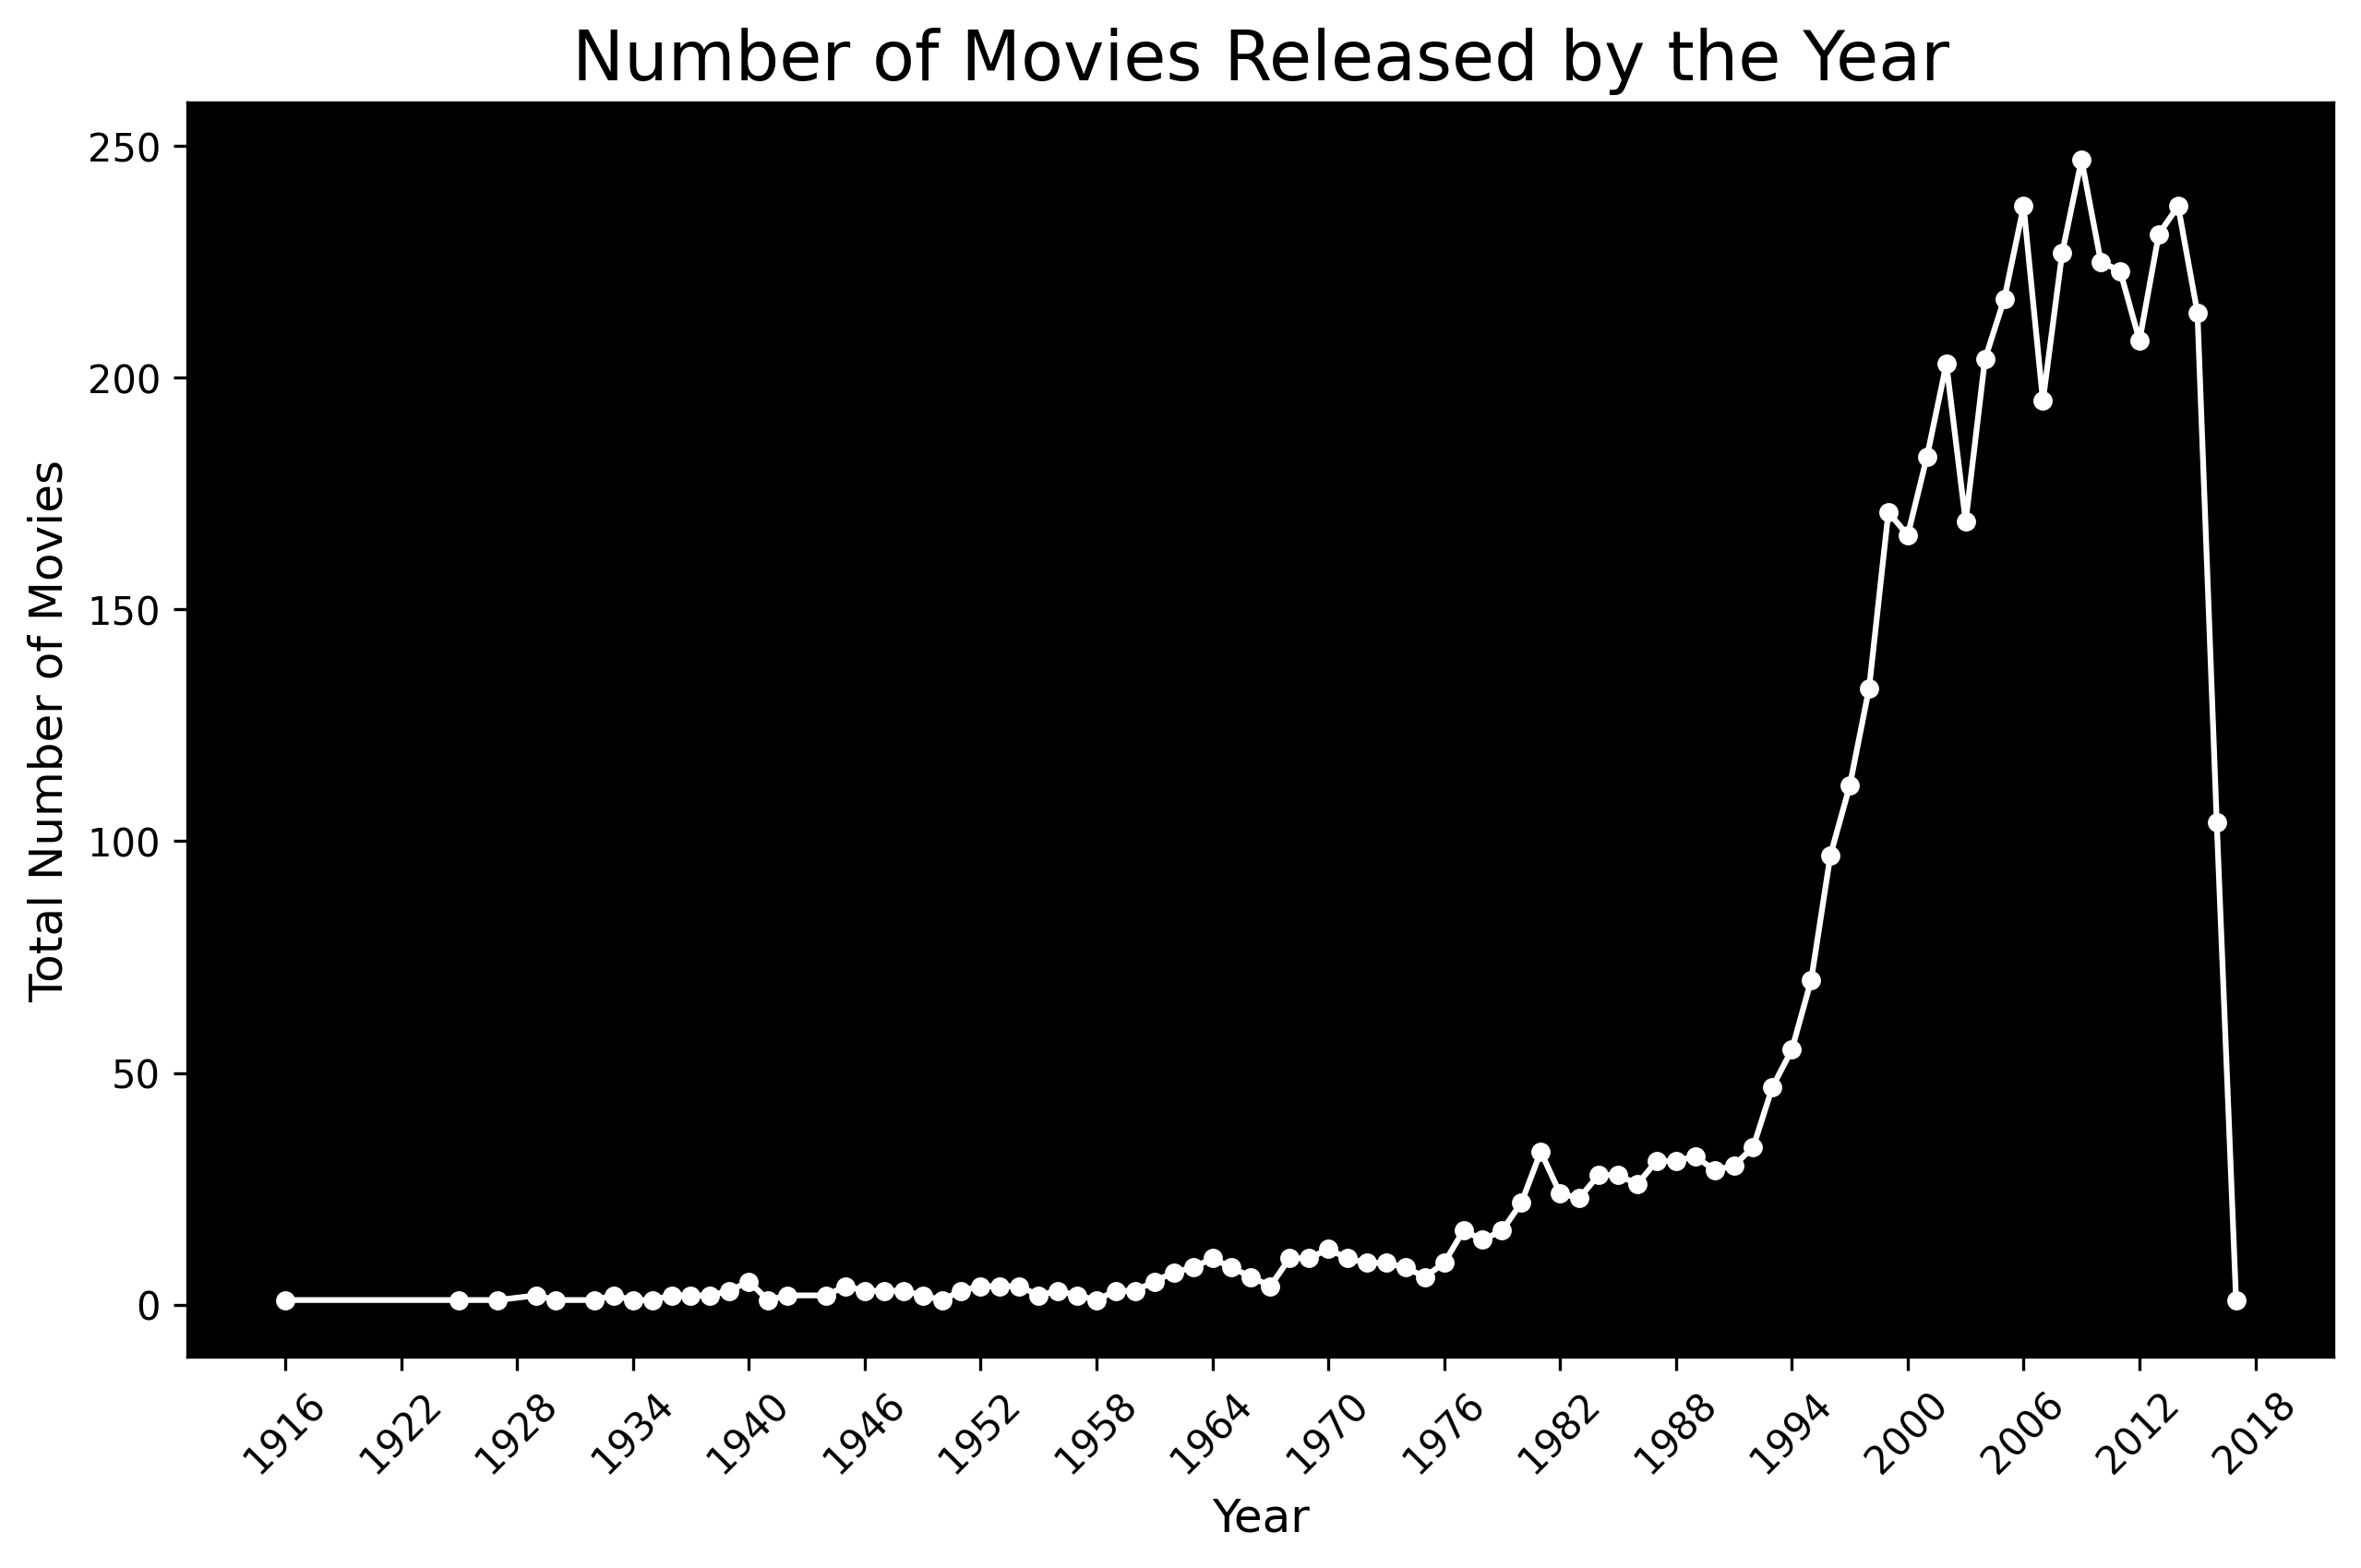

In [39]:
df["release_date"] = pd.to_datetime(df['release_date'], format='%Y-%m-%d')
year_count = df['release_date'].groupby(df["release_date"].dt.year).agg('count')
year_count.plot(color='white', marker="o", markersize="4")
plt.title("Number of Movies Released by the Year", size=18)
plt.xticks(np.arange(min(year_count.index), max(year_count.index)+3,6), rotation=45)
plt.xlabel("Year", size=12)
plt.ylabel("Total Number of Movies", size=12)

In [40]:
df['year']=df['release_data'].dt.strftime('%Y')
df['month']=df['release_date'].dt.month

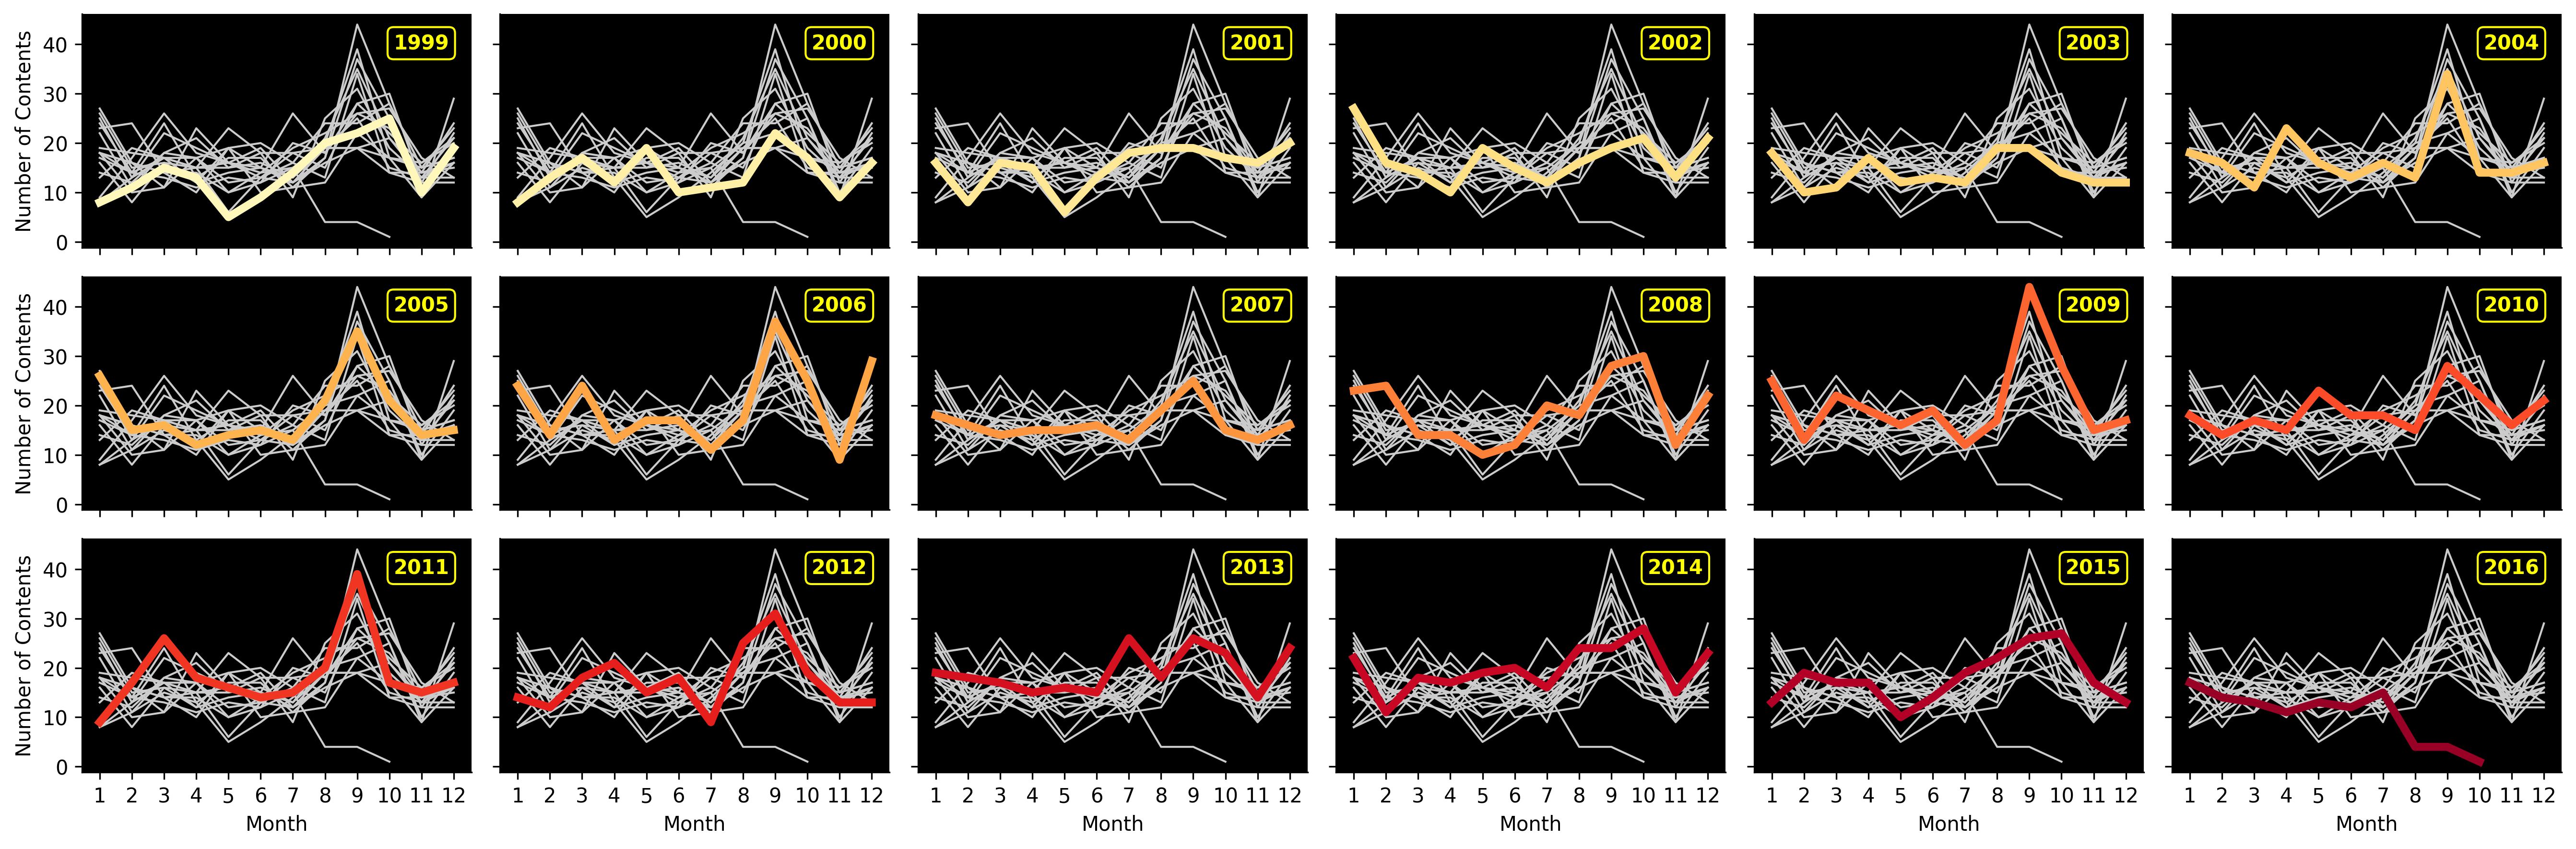

In [45]:
df_btw =df[(df['release_date'].dt.year >= 1999)&(df['release_date'].dt.year <2017)]
df_btw = df_btw.groupby(["year", "month"])["original_title"].count().to_frame().reset_index()
series =sns.relplot(
    data=df_btw,
    x='month',y='original_title',col='year',hue='year',kind='line',palette='YlOrRd',
    linewidth=4,zorder=5,col_wrap=6,height=2,aspect=1.5 ,legend=False
)
for year, ax in series.axes_dict.items():
    
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold", color="yellow",
           bbox=dict(facecolor='none', edgecolor='yellow', boxstyle='round'))
    
    sns.lineplot(
        data=df_btw, x="month", y="original_title", units="year",
        estimator=None, color=".8", linewidth=1, ax=ax)

ax.set_xticks(np.arange(min(df_btw.month), max(df_btw.month)+1, 1))
series.set_titles("")
series.set_axis_labels("Month", "Number of Contents")
series.tight_layout()

In [ ]:
genres=df['genres'].str.split(',',expand=True).stack()
genres=genres.value_counts().reset_index(name='count')
fig= px.treemap( genres,path=['index'], values='count')
fig.update_layout(title_text='Number of Content by Genres',title_x=0.5,title_font=dict(size=18))

fig.update_traces(textinfo="label+value")
fig.show("notebook")

# Content Based similarity
making a model which recommend the use on the basis of content he/she watched.

we are going to use Cosine similarity

# Recommendation based on overview

In [63]:
def overview_based_rec(content_name, df=df):
    
    tfidf = TfidfVectorizer(stop_words='english')
    mtrx = tfidf.fit_transform(df['overview'])
    cosine_sim = linear_kernel(mtrx, mtrx)
    
    ow_sim_df = df.copy()
    ow_sim_df = ow_sim_df.reset_index()
    contents = ow_sim_df["original_title"]
    indices = pd.Series(ow_sim_df.index, index=ow_sim_df['original_title'])
    idx = indices[content_name]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    rec_frame = contents.iloc[movie_indices].to_frame().reset_index(drop=True)
    rec_frame=rec_frame.rename({'original_title':'Recommendations'},axis=1)
    rec_frame=rec_frame.style.set_properties(**{'background-color':'turquoise',
                                              'border':'1.3px solid green',
                                              'color': 'black',
                                              'text-align':'center'
                                              }).set_table_styles([dict(selector='th',
                                                                    props=[('text-align','center'),('background-color','skyblue'),('border-style','solid')]      
                                                                           )])
    return rec_frame                                              




In [64]:
overview_based_rec("Harry Potter and the Half-Blood Prince")

,Recommendations
0,Harry Potter and the Goblet of Fire
1,Harry Potter and the Order of the Phoenix
2,Harry Potter and the Prisoner of Azkaban
3,Harry Potter and the Chamber of Secrets
4,The Little Prince
5,"Run, Hide, Die"
6,Harry Potter and the Philosopher's Stone
7,Plush
8,Sinister 2
9,Domestic Disturbance


# Reccommendation base on Cast,Genres,director and keyword


In [94]:
from sklearn.utils.validation import column_or_1d
def content_based_rec(content_name,dir_weight=1,cast_weight=1,df=df):
  def arrangement(data):
    arr_data=data.split(',')
    arr_data=[i.replace("","").lower() for i in arr_data]
    arr_data=' '.join(map(str,arr_data))
    return arr_data
  
  def cast_func(people):
    names=people.split(',')
    if(len(names)>3):
      names=names[:3]
    names=','.join(map(str,names))
    return names
  
  def cast_dir_arr(data):
    arr_data=' '.join(map(str,data))
    return arr_data
  
  df_rec=df.copy()

  columns_to_arr=['cast','keyword','director','genres']

  for column in columns_to_arr :
    if(column=='cast'):
      df_rec[column]=df_rec[column].apply(cast_func)
    df_rec[column]=df_rec[column].apply(arrangement)

    df_rec['director']=df_rec['director'].apply(lambda x: [x]*dir_weight)
    df_rec['director']=df_rec['director'].apply(cast_dir_arr)


    df_rec['cast']=df_rec['cast'].apply(lambda x: [x]*dir_weight)
    df_rec['cast']=df_rec['cast'].apply(cast_dir_arr)

    df_rec['mix']=df_rec['genres']+" "+df_rec["keywords"]+ " "+ df_rec["cast"]+ " "+df_rec['director']
    count=CountVectorizer(stop_words='english')
    count_matrix=count.fit_transform(df_rec['mix'])
    cos_sim=cosine_similarity(count_matrix,count_matrix)

    df_rec = df_rec.reset_index()
    indices=pd.Series(df_rec.index,index=df_rec["original_title"])

    idx= indices[content_name]

    sim_scores=list(enumerate(cos_sim[idx]))

    sim_scores=sorted(sim_scores,key=lambda x:x[1], reverse=True)

    sim_scores=sim_scores[1:11]

    movie_indices=[i[0] for i in sim_scores]
    
    contents=df_rec["original_title"]
    rec_frame=contents.iloc[movie_indices].to_frame().reset_index(drop=True)
    rec_frame=rec_frame.rename({'original_title':"Recommendation"})
    rec_frame = rec_frame.style.set_properties(**{'background-color': 'pink',
                          'border': '1.3px solid green',
                          'color': 'black', 
                          'text-align': 'center'}).set_table_styles([ dict(selector='th', 
                                                     props=[('text-align', 'center'),
                                                            ('background-color', 'skyblue'),
                                                            ('border-style','solid')])])

    return rec_frame


    

  

In [95]:
content_based_rec("The Smurfs")


,original_title
0,The Smurfs 2
1,Enchanted
2,Aladdin
3,The Chronicles of Narnia: The Voyage of the Dawn Treader
4,Return to Never Land
5,Aliens in the Attic
6,Stuart Little 2
7,The SpongeBob Movie: Sponge Out of Water
8,Up
9,Minions
